In [0]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import random
import time
import os
import sys
from IPython.display import clear_output
import os
tf.autograph.set_verbosity(0)

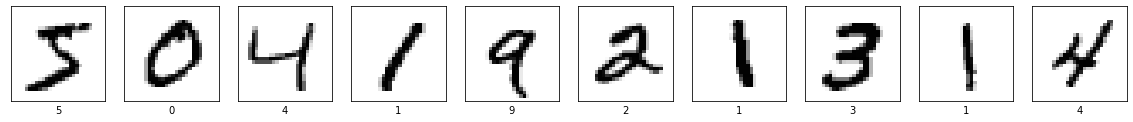

In [0]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

class_names = ['Zero','One', 'Two', 'Three', 'Four', 'Five','Six', 'Seven', 'Eight', 'Nine']
N_image_channels = 1
N_class = len(class_names)
image_shape = x_train.shape[1:3]
input_range = np.amax(x_train)

def plot_images(x_train, y_train, figures_to_plot, pick_random=False, include_labels=True):
    n_rows = np.ceil((figures_to_plot[1])/10)
    plot = plt.figure(figsize=[20,2*n_rows])
    for i in range(figures_to_plot[0],figures_to_plot[1]):
        if pick_random: 
            pic_n = random.randint(0,len(x_train))
        else: pic_n = i
        plt.subplot(n_rows,10,i+1)
        plt.xticks([]); plt.yticks([])
        plt.imshow(x_train[pic_n], cmap=plt.cm.binary)
        if include_labels:
            plt.xlabel(y_train[pic_n])
    plt.show()

plot_images(x_train, y_train, [0,10])

In [0]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train=x_train[0:60000]
y_train=y_train[0:60000]
x_test=x_test[0:10000]
y_test=y_test[0:10000]

class_names = ['Zero','One', 'Two', 'Three', 'Four', 'Five','Six', 'Seven', 'Eight', 'Nine']
N_image_channels = 1
N_class = len(class_names)
N_train = len(y_train)
N_test = len(y_test)
batch_size = 100

train_images = x_train/255
test_images = x_test/255
train_images[train_images >= 0.5] = 1.0
train_images[train_images < 0.5] = 0.0
test_images[test_images >= 0.5] = 1.0
test_images[test_images < 0.5] = 0.0
train_images = train_images.reshape(N_train, 28, 28, N_image_channels).astype('float32')
test_images = test_images.reshape(N_test, 28, 28, N_image_channels).astype('float32')

train_labels = tf.keras.utils.to_categorical(y_train)
test_labels = tf.keras.utils.to_categorical(y_test)

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(N_train).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).shuffle(N_test).batch(batch_size)

In [0]:
class CVAE(tf.keras.Model):
    def __init__(self, z_size):
        super(CVAE, self).__init__()
        self.z_size = z_size
        self.encoder1 = tf.keras.layers.Flatten(input_shape=(28, 28, 1))
        self.encoder11 = tf.keras.layers.concatenate
        self.encoder2 = tf.keras.layers.Dense(512, activation='relu')
        self.encoder3 = tf.keras.layers.Dense(z_size*2)

        self.decoder11 = tf.keras.layers.concatenate
        self.decoder1 = tf.keras.layers.Dense(units=512, activation='relu', input_shape=(z_size+10,))
        self.decoder2 = tf.keras.layers.Dense(784)
        self.decoder3 = tf.keras.layers.Reshape(target_shape=(28, 28, 1))

    def encode(self, x, y):
        x = self.encoder1(x)
        x = self.encoder11([x, y], axis=1)
        x = self.encoder2(x)
        x = self.encoder3(x)
        encoder_nn_output = x
        z_mean, z_logvar = tf.split(encoder_nn_output, num_or_size_splits=2, axis=1)
        return z_mean, z_logvar

    def reparameterize(self, z_mean, z_logvar):
        epsilon = tf.random.normal(shape=z_mean.shape)
        z_sampled = epsilon * tf.exp(z_logvar * 0.5) + z_mean
        return z_sampled   

    def decode(self, z, y):
        z = self.decoder11([z, y], axis=1)
        z = self.decoder1(z)
        z = self.decoder2(z)
        z = self.decoder3(z)
        pixel_output = z
        pixel_prob = tf.math.sigmoid(pixel_output)
        return pixel_prob

In [0]:
def calculate_ELBO(model, x, y):
    z_mean, z_logvar = model.encode(x, y)
    z = model.reparameterize(z_mean, z_logvar)
    
    pixel_prob = model.decode(z, y)
    
    logpx_z_pixels = tf.math.log(pixel_prob + 1e-10)*x + tf.math.log(1-pixel_prob + 1e-10)*(1-x)
    logpx_z_images = tf.reduce_sum(logpx_z_pixels, axis=[1, 2, 3])
    logpx_z = tf.reduce_mean (logpx_z_images)
    
    KL_parameters = -0.5 * (1 + z_logvar - (z_mean ** 2.0) - tf.exp(z_logvar))
    KL_vectors = tf.reduce_sum(KL_parameters, axis=1)
    KL = tf.reduce_mean(KL_vectors)
    
    ELBO = (logpx_z - KL)
    
    return -ELBO #Negative because we want to maximise it

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

In [0]:
def train_step(model, x, y, optimizer):
    with tf.GradientTape() as tape:
        loss = calculate_ELBO(model, x, y)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_loss(loss)

def test_step(model, x, y, optimizer):
    loss = calculate_ELBO(model, x, y)
    test_loss(loss)

In [0]:
def generate_images(model, z_random, y, figures_to_plot):
    generated_prob = model.decode(z_random, y)
    generated_prob = np.squeeze(generated_prob, axis=3)
    plot_images(generated_prob, _, figures_to_plot, include_labels=False)

In [0]:
def train_test_dataset(model, train_dataset, test_dataset, epochs, generate=True):
  plots_per_epoch = 10
  z_random = tf.random.normal(shape=[plots_per_epoch, z_size])
  y_generate = np.eye(10)

  test_ELBO = []
  train_ELBO = []
  epoch_number = []  
  for epoch in range(epochs):
    print('Epoch {}'.format(epoch))
    for train_x, train_y in train_dataset: 
      train_step(model, train_x, train_y, optimizer)
  
    for test_x, test_y in test_dataset:
      test_step(model, test_x, test_y, optimizer)
    
    test_ELBO.append(-test_loss.result())
    train_ELBO.append(-train_loss.result())
    epoch_number.append(epoch)
    
    clear_output()
    if generate:
      generate_images(model, z_random, y_generate, [0,plots_per_epoch])
    plt.plot(epoch_number, test_ELBO, train_ELBO)
    plt.legend(['test','train'])
    plt.title('model')
    plt.show()
  train_loss.reset_states()
  test_loss.reset_states()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



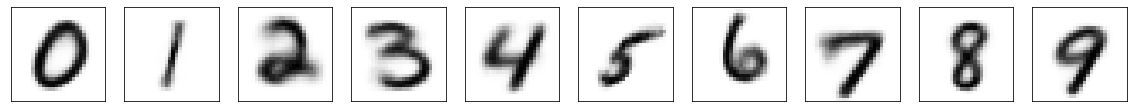

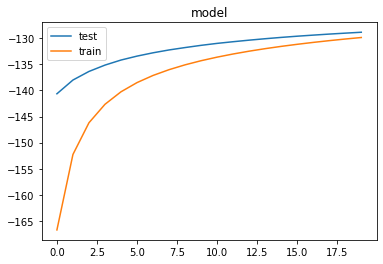

In [0]:
z_size = 2
model = CVAE(z_size)
train_test_dataset(model, train_dataset, test_dataset, 20, generate=True)

#### Reconstruct images

Original Pictures:


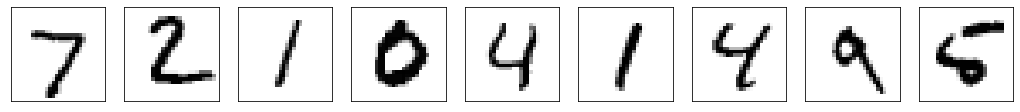

Reconstructed Pictures, with ELBO loss:


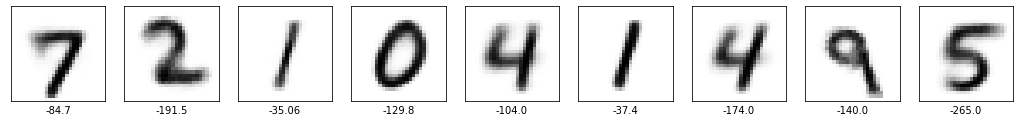

In [0]:
def reconstruct_images(model, images, labels):
    images_n = len(images)
    x = images/255
    x[x >= 0.5] = 1.0
    x[x < 0.5] = 0.0
    x = x.reshape(images_n, image_shape[0], image_shape[1], N_image_channels).astype('float32')
    y = tf.keras.utils.to_categorical(labels)
    
    z_mean, z_logvar = model.encode(x, y)
    z = model.reparameterize(z_mean, z_logvar)
    pixel_output = model.decode(z, y)
    pixel_prob = tf.math.sigmoid(pixel_output)
    pixel_prob = np.squeeze(pixel_prob, axis=3)

    loss = np.empty([images_n])
    for i in range(images_n):
        loss[i] = calculate_ELBO(model,x[i:i+1], y[i:i+1])
    loss = loss.astype('float16')
    
    print('Original Pictures:')
    plot_images(images, _, figures_to_plot=[0,images_n], include_labels=False)
    print('Reconstructed Pictures, with ELBO loss:')
    plot_images(pixel_prob, -loss, figures_to_plot=[0,images_n], include_labels=True)

reconstruct_images(model, x_test[0:9], y_test[0:9])

#### Visualise latent space

0 Outliers detected


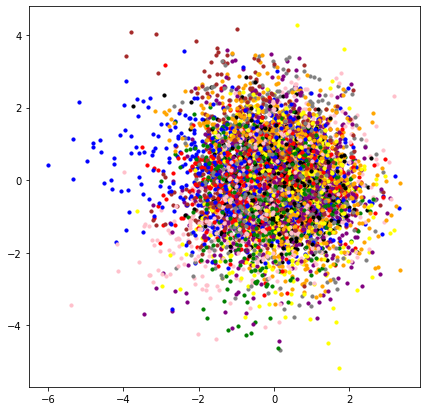

In [0]:
def visualize_latent_space(model, range1, range2, data_x, data_y, a, b):
  plot = plt.figure(figsize=[7,7])
  outliers=0
  for i in range(range1, range2):
    pic_visualize = data_x[i]
    pic_visualize = pic_visualize.reshape(1, image_shape[0], image_shape[1], N_image_channels).astype('float32')
    label_visualize = data_y[i]
    label_visualize = label_visualize.reshape(1, 10)
    
    z_mean, z_logvar = model.encode(pic_visualize, label_visualize)
    z = model.reparameterize(z_mean, z_logvar)
    num=np.argmax(label_visualize)

    if num == 0:
      color = 'blue'
    if num == 1:
      color = 'orange'
    if num == 2:
      color = 'green'
    if num == 3:
      color = 'red'
    if num == 4:
      color = 'purple'  
    if num == 5:
      color = 'brown'
    if num == 6:
      color = 'pink'
    if num == 7:
      color = 'gray'
    if num == 8:
      color = 'black'
    if num == 9:
      color = 'yellow'
    plt.scatter(z[:,a],z[:,b], color=color, s=10)
  print('{} Outliers detected'.format(outliers))


visualize_latent_space(model, 0,10000, test_images, test_labels, 0,1)

#### Generate numbers


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



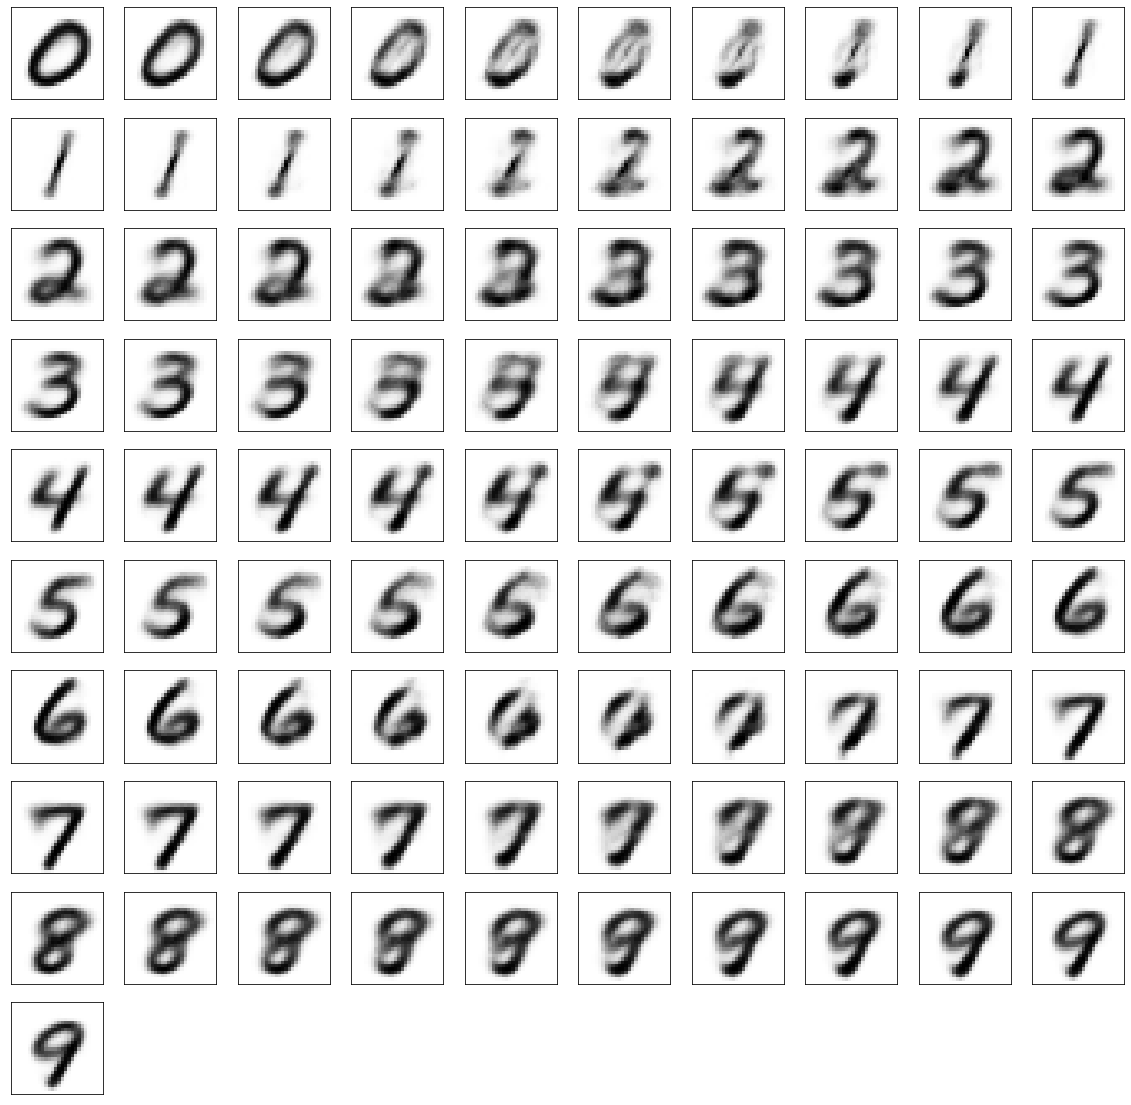

In [0]:
z_random = tf.random.normal(shape=[1, z_size])
y_generate = np.zeros((91,10+z_size))
for i in range(90):
  m = i // 10
  r = i % 10
  y_generate[i, m+z_size] = 1 - r*0.1
  y_generate[i, m + z_size+1]= r *0.1
y_generate[-1,-1]=1
y_generate[:,:z_size] = z_random
generate_images(model, y_generate[:,:z_size], y_generate[:,z_size:], [0,91])

#### Classify test images

In [0]:
images = x_test
predicted_class = np.zeros([1,len(images)])
images_n = len(images)
x = images/255
x[x >= 0.5] = 1.0
x[x < 0.5] = 0.0
x = x.reshape(images_n, image_shape[0], image_shape[1], N_image_channels).astype('float32')
loss = np.empty([images_n,10])

for j in range(10):
  print(j)
  ytest = np.ones([len(images),])*j
  y = tf.keras.utils.to_categorical(ytest, num_classes=10)
  for i in range(images_n):
      loss[i,j] = calculate_ELBO(model,x[i:i+1], y[i:i+1])

for i in range(images_n):
  predicted_class[0,i] = np.argmin(loss[i,:])
print(predicted_class)

0
1
2
3
4
5
6
7
8
9
[[7. 2. 1. ... 4. 5. 6.]]


Correctly labelled pictures:9293/10000 -> Accuracy: 92.93%
Incorrectly labelled pictures:707/10000 -> Error: 7.0699999999999985%


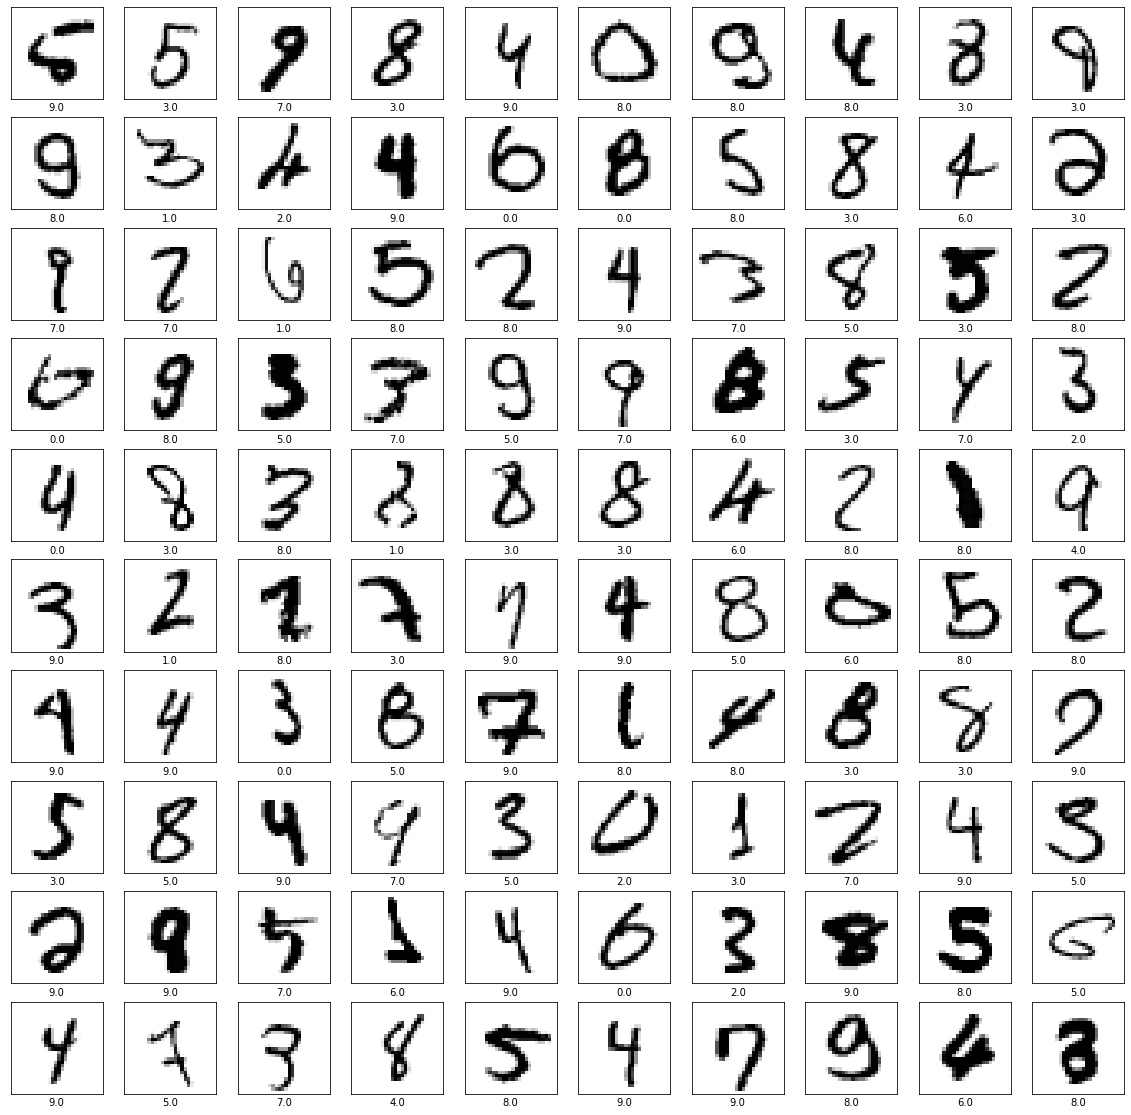

In [0]:
correct_guesses = 0
wrong_guesses = []
for i,x in enumerate(zip(predicted_class[0,:], y_test)):
    if (x[0]==x[1]):
        correct_guesses = correct_guesses + 1
    else:
        wrong_guesses.append(i)
    total_guesses = len(y_test)
    accuracy = (correct_guesses/total_guesses)
print('Correctly labelled pictures:{}/{} -> Accuracy: {}%'.format(correct_guesses,total_guesses,accuracy*100))
print('Incorrectly labelled pictures:{}/{} -> Error: {}%'.format(total_guesses-correct_guesses,total_guesses,(1-accuracy)*100))


pics_to_plot = list(x_test[i] for i in wrong_guesses)
labels = list(predicted_class[0,i] for i in wrong_guesses)
plot_images(pics_to_plot[0:100], labels[0:100], [0,len(labels[0:100])])
